In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torch.optim as optim

In [ ]:
# !git clone https://github.com/broccubali/NoisyICML.git

Cloning into 'NoisyICML'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 320 (delta 49), reused 64 (delta 16), pack-reused 202 (from 1)
Receiving objects: 100% (320/320), 88.75 MiB | 32.71 MiB/s, done.
Resolving deltas: 100% (142/142), done.


In [2]:
# again.
import torch.nn.init as init
class PINN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList(
            [
                nn.Linear(input_size if i == 0 else hidden_size, hidden_size)
                if i % 2 == 0
                else nn.SiLU()
                for i in range(10)
            ]
        )
        self.layers.append(nn.Linear(hidden_size, output_size))
        for layer in self.layers:
            if isinstance(layer, nn.Linear):
                init.xavier_normal_(layer.weight)  # Initialize weights
                if layer.bias is not None:  # Initialize biases to zero
                    init.zeros_(layer.bias)

        # Trainable parameter for the wave number squared (k^2)
        self.k = nn.Parameter(torch.tensor([5], dtype=torch.float32, device="cuda"))

        self.optimizer = optim.Adam(self.parameters(), lr=1e-2)
        self.loss = nn.MSELoss()
        # self.k = 5

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def loss_fn(self, train, u):
        u_pred = self.forward(train)
        return self.loss(u_pred, u)

    def residual_loss(self, train):
        # Physics-informed loss based on the Helmholtz equation
        g = train.clone()
        g.requires_grad = True
        u_pred = self.forward(g)

        # Compute the gradients for second derivatives (u_xx and u_tt)
        u_x = torch.autograd.grad(
            u_pred, g, torch.ones_like(u_pred), create_graph=True, retain_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, g, torch.ones_like(g), create_graph=True
        )[0] # <---- Similar modification to select the second derivative with respect to X

        k2 = (self.k**2) * np.pi**2
        fhat = -k2 * torch.sin(self.k * np.pi * g) 
        residual = u_xx  + ((self.k) * u_pred) - fhat # <---- Also fixed k to k2
        return self.loss(residual, torch.zeros_like(residual))

    def total_loss(self, train, utrain,):
        alpha_female = 0.5
        data_loss = self.loss_fn(train, utrain)  # Match observed data
        physics_loss = self.residual_loss(train)  # Enforce governing equations
        return data_loss, physics_loss, data_loss + physics_loss

    def train_model(self, train, utrain, epochs=100):
        self.train()
        for epoch in tqdm(range(epochs)):
            self.optimizer.zero_grad()
            data_loss, physics_loss, loss = self.total_loss(train, utrain)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=10.0)  # Adjust max_norm if needed
            self.optimizer.step()
            if epoch % 200 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss = {loss.item()}, Data Loss = {data_loss.item()}, Physics Loss = {physics_loss.item()}, k = {self.k.item()}")

In [22]:
x = np.linspace(-1, 1, 1024)
k = 5
u_true = np.sin(k * np.pi * x) 
u_true.shape

(1024,)

In [4]:
from scipy.stats import skewnorm
noise = skewnorm.rvs(a=1, scale=0.2, size=1024)
u_train = u_true + noise

In [5]:
device = "cuda"
X_train = torch.tensor(x, dtype=torch.float32).to(device).unsqueeze(1)
U_train = torch.tensor(u_train, dtype=torch.float32).to(device).unsqueeze(1)
X_train.shape, U_train.shape

(torch.Size([1024, 1]), torch.Size([1024, 1]))

In [6]:
idx = np.random.choice(X_train.shape[0], 512, replace=False)
X_train = X_train[idx]
U_train = U_train[idx, 0]
X_train.shape, U_train.shape

(torch.Size([512, 1]), torch.Size([512]))

In [7]:
model = PINN(input_size=1, hidden_size=20, output_size=1).to(device)
model.train_model(X_train, U_train, epochs=20000)

  0%|          | 0/20000 [00:00<?, ?it/s]/home/shusrith/projects/torch/lib/python3.12/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/shusrith/projects/torch/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 20/20000 [00:00<04:03, 82.13it/s] 

Epoch 1/20000, Loss = 29988.220703125, Data Loss = 0.5252355337142944, Physics Loss = 29987.6953125, k = 4.989999771118164


  1%|          | 245/20000 [00:01<01:26, 229.28it/s]

Epoch 201/20000, Loss = 334.55615234375, Data Loss = 95.63259887695312, Physics Loss = 238.9235382080078, k = 3.867672920227051


  2%|▏         | 444/20000 [00:02<01:22, 237.71it/s]

Epoch 401/20000, Loss = 161.10397338867188, Data Loss = 20.572818756103516, Physics Loss = 140.53115844726562, k = 3.73264741897583


  3%|▎         | 640/20000 [00:02<01:24, 229.10it/s]

Epoch 601/20000, Loss = 21.981111526489258, Data Loss = 4.082033157348633, Physics Loss = 17.899078369140625, k = 3.6658053398132324


  4%|▍         | 846/20000 [00:03<01:26, 222.18it/s]

Epoch 801/20000, Loss = 54.026023864746094, Data Loss = 1.2678511142730713, Physics Loss = 52.75817108154297, k = 3.6234254837036133


  5%|▌         | 1031/20000 [00:04<01:23, 228.16it/s]

Epoch 1001/20000, Loss = 26.58782386779785, Data Loss = 1.0593477487564087, Physics Loss = 25.52847671508789, k = 3.591933488845825


  6%|▌         | 1227/20000 [00:05<01:18, 240.24it/s]

Epoch 1201/20000, Loss = 73.51278686523438, Data Loss = 1.032493233680725, Physics Loss = 72.48029327392578, k = 3.5621767044067383


  7%|▋         | 1441/20000 [00:06<01:26, 213.42it/s]

Epoch 1401/20000, Loss = 23.5554141998291, Data Loss = 1.0512068271636963, Physics Loss = 22.504207611083984, k = 3.5236828327178955


  8%|▊         | 1627/20000 [00:07<01:17, 235.87it/s]

Epoch 1601/20000, Loss = 43.32752990722656, Data Loss = 1.0807311534881592, Physics Loss = 42.24679946899414, k = 3.4836273193359375


  9%|▉         | 1822/20000 [00:08<01:21, 224.32it/s]

Epoch 1801/20000, Loss = 19.36354637145996, Data Loss = 1.0389246940612793, Physics Loss = 18.324621200561523, k = 3.442960500717163


 10%|█         | 2027/20000 [00:09<01:20, 223.39it/s]

Epoch 2001/20000, Loss = 27.571998596191406, Data Loss = 1.0298187732696533, Physics Loss = 26.542179107666016, k = 3.3897972106933594


 11%|█         | 2243/20000 [00:10<01:26, 204.65it/s]

Epoch 2201/20000, Loss = 58.55887222290039, Data Loss = 1.0327285528182983, Physics Loss = 57.52614212036133, k = 3.327704429626465


 12%|█▏        | 2435/20000 [00:11<01:28, 198.96it/s]

Epoch 2401/20000, Loss = 18.677188873291016, Data Loss = 1.0149505138397217, Physics Loss = 17.66223907470703, k = 3.236924648284912


 13%|█▎        | 2625/20000 [00:12<01:23, 208.28it/s]

Epoch 2601/20000, Loss = 9.054108619689941, Data Loss = 1.0166467428207397, Physics Loss = 8.03746223449707, k = 3.182072401046753


 14%|█▍        | 2835/20000 [00:13<01:25, 201.21it/s]

Epoch 2801/20000, Loss = 8.292410850524902, Data Loss = 1.026428461074829, Physics Loss = 7.265982151031494, k = 3.1174161434173584


 15%|█▌        | 3026/20000 [00:14<01:18, 215.24it/s]

Epoch 3001/20000, Loss = 8.330940246582031, Data Loss = 1.038331151008606, Physics Loss = 7.292609214782715, k = 3.0283429622650146


 16%|█▌        | 3235/20000 [00:15<01:16, 218.79it/s]

Epoch 3201/20000, Loss = 5.256691932678223, Data Loss = 1.0548932552337646, Physics Loss = 4.201798439025879, k = 2.963552713394165


 17%|█▋        | 3425/20000 [00:16<01:27, 190.42it/s]

Epoch 3401/20000, Loss = 8.848062515258789, Data Loss = 1.0869252681732178, Physics Loss = 7.761137008666992, k = 2.8906569480895996


 18%|█▊        | 3639/20000 [00:17<01:24, 193.19it/s]

Epoch 3601/20000, Loss = 4.495654582977295, Data Loss = 1.0821294784545898, Physics Loss = 3.413525104522705, k = 2.8353490829467773


 19%|█▉        | 3840/20000 [00:18<01:22, 195.06it/s]

Epoch 3801/20000, Loss = 3.088714838027954, Data Loss = 1.0877270698547363, Physics Loss = 2.0009877681732178, k = 2.7941267490386963


 20%|██        | 4021/20000 [00:19<01:11, 224.97it/s]

Epoch 4001/20000, Loss = 9.67746353149414, Data Loss = 1.090802550315857, Physics Loss = 8.586661338806152, k = 2.749516725540161


 21%|██        | 4224/20000 [00:19<01:12, 218.74it/s]

Epoch 4201/20000, Loss = 5.22376012802124, Data Loss = 1.0883315801620483, Physics Loss = 4.135428428649902, k = 2.7172248363494873


 22%|██▏       | 4445/20000 [00:21<01:12, 214.62it/s]

Epoch 4401/20000, Loss = 1.7646981477737427, Data Loss = 1.089484691619873, Physics Loss = 0.6752134561538696, k = 2.6934304237365723


 23%|██▎       | 4627/20000 [00:21<01:08, 224.32it/s]

Epoch 4601/20000, Loss = 2.068203926086426, Data Loss = 1.089050531387329, Physics Loss = 0.9791532754898071, k = 2.6729953289031982


 24%|██▍       | 4823/20000 [00:22<01:14, 202.84it/s]

Epoch 4801/20000, Loss = 5.160137176513672, Data Loss = 1.0951430797576904, Physics Loss = 4.064993858337402, k = 2.6397948265075684


 25%|██▌       | 5037/20000 [00:23<01:12, 205.25it/s]

Epoch 5001/20000, Loss = 3.6258492469787598, Data Loss = 1.0890898704528809, Physics Loss = 2.536759376525879, k = 2.607520341873169


 26%|██▌       | 5225/20000 [00:24<01:11, 206.86it/s]

Epoch 5201/20000, Loss = 3.0544919967651367, Data Loss = 1.0857112407684326, Physics Loss = 1.9687806367874146, k = 2.575505495071411


 27%|██▋       | 5425/20000 [00:25<01:09, 210.07it/s]

Epoch 5401/20000, Loss = 1.4282232522964478, Data Loss = 1.0837376117706299, Physics Loss = 0.34448564052581787, k = 2.528388500213623


 28%|██▊       | 5632/20000 [00:26<01:03, 227.98it/s]

Epoch 5601/20000, Loss = 3.528301954269409, Data Loss = 1.0527586936950684, Physics Loss = 2.475543260574341, k = 2.441581964492798


 29%|██▉       | 5826/20000 [00:27<01:09, 203.67it/s]

Epoch 5801/20000, Loss = 5.672860145568848, Data Loss = 1.01407790184021, Physics Loss = 4.658782482147217, k = 2.338317632675171


 30%|███       | 6034/20000 [00:28<01:07, 207.23it/s]

Epoch 6001/20000, Loss = 10.408899307250977, Data Loss = 0.9961450099945068, Physics Loss = 9.41275405883789, k = 2.2292094230651855


 31%|███       | 6240/20000 [00:29<00:57, 238.03it/s]

Epoch 6201/20000, Loss = 3.585496425628662, Data Loss = 0.9885300397872925, Physics Loss = 2.59696626663208, k = 2.0710089206695557


 32%|███▏      | 6432/20000 [00:30<01:01, 219.44it/s]

Epoch 6401/20000, Loss = 1.9115867614746094, Data Loss = 1.004406452178955, Physics Loss = 0.9071803689002991, k = 1.9779301881790161


 33%|███▎      | 6627/20000 [00:31<01:09, 192.02it/s]

Epoch 6601/20000, Loss = 1.466923475265503, Data Loss = 1.0328621864318848, Physics Loss = 0.4340612292289734, k = 1.8892940282821655


 34%|███▍      | 6846/20000 [00:32<00:58, 226.36it/s]

Epoch 6801/20000, Loss = 1.4952993392944336, Data Loss = 1.038304328918457, Physics Loss = 0.4569949507713318, k = 1.8542946577072144


 35%|███▌      | 7038/20000 [00:33<00:54, 238.31it/s]

Epoch 7001/20000, Loss = 1.3854358196258545, Data Loss = 1.0458550453186035, Physics Loss = 0.3395807147026062, k = 1.8295862674713135


 36%|███▌      | 7224/20000 [00:34<00:57, 223.80it/s]

Epoch 7201/20000, Loss = 1.312750220298767, Data Loss = 1.056757926940918, Physics Loss = 0.2559922933578491, k = 1.7983553409576416


 37%|███▋      | 7442/20000 [00:35<00:51, 242.01it/s]

Epoch 7401/20000, Loss = 1.2530466318130493, Data Loss = 1.0623013973236084, Physics Loss = 0.19074523448944092, k = 1.7769880294799805


 38%|███▊      | 7627/20000 [00:36<00:59, 207.00it/s]

Epoch 7601/20000, Loss = 1.4039826393127441, Data Loss = 1.066374659538269, Physics Loss = 0.3376079797744751, k = 1.7623698711395264


 39%|███▉      | 7843/20000 [00:37<00:56, 216.62it/s]

Epoch 7801/20000, Loss = 1.3211684226989746, Data Loss = 1.0702853202819824, Physics Loss = 0.25088316202163696, k = 1.7507376670837402


 40%|████      | 8037/20000 [00:38<00:55, 215.08it/s]

Epoch 8001/20000, Loss = 1.4532666206359863, Data Loss = 1.0736075639724731, Physics Loss = 0.37965911626815796, k = 1.7425360679626465


 41%|████      | 8233/20000 [00:39<00:55, 213.37it/s]

Epoch 8201/20000, Loss = 1.2809288501739502, Data Loss = 1.0757527351379395, Physics Loss = 0.20517605543136597, k = 1.7353675365447998


 42%|████▏     | 8425/20000 [00:39<00:56, 203.82it/s]

Epoch 8401/20000, Loss = 1.7706868648529053, Data Loss = 1.072536587715149, Physics Loss = 0.6981502175331116, k = 1.7285407781600952


 43%|████▎     | 8622/20000 [00:40<00:52, 217.42it/s]

Epoch 8601/20000, Loss = 1.2621933221817017, Data Loss = 1.0816824436187744, Physics Loss = 0.18051084876060486, k = 1.7102150917053223


 44%|████▍     | 8830/20000 [00:42<00:56, 196.12it/s]

Epoch 8801/20000, Loss = 1.1823079586029053, Data Loss = 1.0941678285598755, Physics Loss = 0.0881401002407074, k = 1.6718829870224


 45%|████▌     | 9029/20000 [00:42<00:49, 220.91it/s]

Epoch 9001/20000, Loss = 1.2239576578140259, Data Loss = 1.0960693359375, Physics Loss = 0.12788832187652588, k = 1.6317096948623657


 46%|████▌     | 9243/20000 [00:44<00:51, 207.40it/s]

Epoch 9201/20000, Loss = 1.2862685918807983, Data Loss = 1.0983612537384033, Physics Loss = 0.1879073828458786, k = 1.5932852029800415


 47%|████▋     | 9422/20000 [00:44<00:55, 190.94it/s]

Epoch 9401/20000, Loss = 1.5665524005889893, Data Loss = 1.0809030532836914, Physics Loss = 0.48564934730529785, k = 1.5323024988174438


 48%|████▊     | 9635/20000 [00:46<00:57, 179.17it/s]

Epoch 9601/20000, Loss = 1.2247353792190552, Data Loss = 1.0630958080291748, Physics Loss = 0.16163954138755798, k = 1.4646838903427124


 49%|████▉     | 9829/20000 [00:47<00:59, 171.05it/s]

Epoch 9801/20000, Loss = 1.4215583801269531, Data Loss = 1.0251692533493042, Physics Loss = 0.39638906717300415, k = 1.3400894403457642


 50%|█████     | 10045/20000 [00:48<00:45, 220.66it/s]

Epoch 10001/20000, Loss = 0.7851908802986145, Data Loss = 0.783893346786499, Physics Loss = 0.0012975436402484775, k = 1.0702282190322876


 51%|█████     | 10223/20000 [00:49<00:54, 178.68it/s]

Epoch 10201/20000, Loss = 0.5852279663085938, Data Loss = 0.5850666165351868, Physics Loss = 0.00016135633632075042, k = 0.7749166488647461


 52%|█████▏    | 10420/20000 [00:50<00:49, 195.05it/s]

Epoch 10401/20000, Loss = 0.5375484228134155, Data Loss = 0.5374394655227661, Physics Loss = 0.00010896680760197341, k = 0.6209657788276672


 53%|█████▎    | 10630/20000 [00:51<00:48, 192.98it/s]

Epoch 10601/20000, Loss = 0.5247586369514465, Data Loss = 0.5247180461883545, Physics Loss = 4.058717604493722e-05, k = 0.5355687737464905


 54%|█████▍    | 10839/20000 [00:52<00:44, 208.17it/s]

Epoch 10801/20000, Loss = 0.5198295712471008, Data Loss = 0.5198018550872803, Physics Loss = 2.7705023967428133e-05, k = 0.4802284836769104


 55%|█████▌    | 11021/20000 [00:53<00:46, 194.65it/s]

Epoch 11001/20000, Loss = 0.5175509452819824, Data Loss = 0.5175390839576721, Physics Loss = 1.1879643352585845e-05, k = 0.44021427631378174


 56%|█████▌    | 11241/20000 [00:54<00:44, 197.27it/s]

Epoch 11201/20000, Loss = 0.5163158774375916, Data Loss = 0.5163040161132812, Physics Loss = 1.186217377835419e-05, k = 0.4092460572719574


 57%|█████▋    | 11424/20000 [00:55<00:38, 222.79it/s]

Epoch 11401/20000, Loss = 0.515658974647522, Data Loss = 0.5155436992645264, Physics Loss = 0.00011525157606229186, k = 0.3840686082839966


 58%|█████▊    | 11627/20000 [00:56<00:37, 224.15it/s]

Epoch 11601/20000, Loss = 0.515113115310669, Data Loss = 0.5151066780090332, Physics Loss = 6.4298760662495624e-06, k = 0.36300981044769287


 59%|█████▉    | 11839/20000 [00:57<00:40, 199.99it/s]

Epoch 11801/20000, Loss = 0.5147989988327026, Data Loss = 0.514794111251831, Physics Loss = 4.896796781395096e-06, k = 0.3448449373245239


 60%|██████    | 12024/20000 [00:58<00:40, 196.78it/s]

Epoch 12001/20000, Loss = 0.5145794749259949, Data Loss = 0.5145754814147949, Physics Loss = 3.967462816945044e-06, k = 0.32886695861816406


 61%|██████    | 12235/20000 [00:59<00:37, 207.70it/s]

Epoch 12201/20000, Loss = 0.5144215226173401, Data Loss = 0.514418363571167, Physics Loss = 3.176441168761812e-06, k = 0.31464284658432007


 62%|██████▏   | 12419/20000 [01:00<00:42, 177.57it/s]

Epoch 12401/20000, Loss = 0.5143046975135803, Data Loss = 0.5143020153045654, Physics Loss = 2.6712805265560746e-06, k = 0.3017531931400299


 63%|██████▎   | 12624/20000 [01:01<00:39, 186.98it/s]

Epoch 12601/20000, Loss = 0.5142168402671814, Data Loss = 0.5142146944999695, Physics Loss = 2.1749660845671315e-06, k = 0.29003867506980896


 64%|██████▍   | 12824/20000 [01:02<00:40, 179.36it/s]

Epoch 12801/20000, Loss = 0.5141493678092957, Data Loss = 0.5141474008560181, Physics Loss = 1.9596175206970656e-06, k = 0.27919432520866394


 65%|██████▌   | 13025/20000 [01:03<00:36, 193.37it/s]

Epoch 13001/20000, Loss = 0.5140969753265381, Data Loss = 0.5140954256057739, Physics Loss = 1.5514956430706661e-06, k = 0.2692098319530487


 66%|██████▌   | 13230/20000 [01:04<00:33, 202.57it/s]

Epoch 13201/20000, Loss = 0.5140557289123535, Data Loss = 0.5140540599822998, Physics Loss = 1.6960033235591254e-06, k = 0.2597983777523041


 67%|██████▋   | 13429/20000 [01:05<00:30, 213.60it/s]

Epoch 13401/20000, Loss = 0.5140226483345032, Data Loss = 0.5140215158462524, Physics Loss = 1.1368840659997659e-06, k = 0.2510916292667389


 68%|██████▊   | 13623/20000 [01:06<00:30, 206.62it/s]

Epoch 13601/20000, Loss = 0.5146948099136353, Data Loss = 0.5145293474197388, Physics Loss = 0.00016545361722819507, k = 0.24281102418899536


 69%|██████▉   | 13816/20000 [01:07<00:37, 165.14it/s]

Epoch 13801/20000, Loss = 0.5139747858047485, Data Loss = 0.5139739513397217, Physics Loss = 8.629860985820414e-07, k = 0.23501308262348175


 70%|███████   | 14031/20000 [01:09<00:28, 208.48it/s]

Epoch 14001/20000, Loss = 0.5144118666648865, Data Loss = 0.5143440961837769, Physics Loss = 6.778833630960435e-05, k = 0.22759869694709778


 71%|███████   | 14223/20000 [01:10<00:32, 175.67it/s]

Epoch 14201/20000, Loss = 0.5139430165290833, Data Loss = 0.5139423608779907, Physics Loss = 6.538397769872972e-07, k = 0.2205592542886734


 72%|███████▏  | 14418/20000 [01:11<00:29, 191.96it/s]

Epoch 14401/20000, Loss = 0.5139356851577759, Data Loss = 0.5139346122741699, Physics Loss = 1.0751467698355555e-06, k = 0.21384042501449585


 73%|███████▎  | 14621/20000 [01:12<00:28, 185.51it/s]

Epoch 14601/20000, Loss = 0.5139214396476746, Data Loss = 0.5139209032058716, Physics Loss = 5.157005489309086e-07, k = 0.20739296078681946


 74%|███████▍  | 14836/20000 [01:13<00:28, 179.83it/s]

Epoch 14801/20000, Loss = 0.5139133930206299, Data Loss = 0.5139131546020508, Physics Loss = 2.4884718641260406e-07, k = 0.20120060443878174


 75%|███████▌  | 15028/20000 [01:14<00:26, 189.04it/s]

Epoch 15001/20000, Loss = 0.5139064192771912, Data Loss = 0.5139060020446777, Physics Loss = 4.159668378633796e-07, k = 0.19523867964744568


 76%|███████▌  | 15229/20000 [01:15<00:26, 177.11it/s]

Epoch 15201/20000, Loss = 0.513900637626648, Data Loss = 0.5139002799987793, Physics Loss = 3.765464100524696e-07, k = 0.1895296722650528


 77%|███████▋  | 15442/20000 [01:16<00:19, 228.90it/s]

Epoch 15401/20000, Loss = 0.5138957500457764, Data Loss = 0.5138953924179077, Physics Loss = 3.420535676923464e-07, k = 0.18397165834903717


 78%|███████▊  | 15626/20000 [01:17<00:19, 227.87it/s]

Epoch 15601/20000, Loss = 0.5138916373252869, Data Loss = 0.513891339302063, Physics Loss = 3.1140990586209227e-07, k = 0.1785643994808197


 79%|███████▉  | 15820/20000 [01:18<00:19, 211.39it/s]

Epoch 15801/20000, Loss = 0.517742395401001, Data Loss = 0.5174456834793091, Physics Loss = 0.00029669434297829866, k = 0.17342977225780487


 80%|████████  | 16036/20000 [01:19<00:19, 199.17it/s]

Epoch 16001/20000, Loss = 0.5138852000236511, Data Loss = 0.5138849020004272, Physics Loss = 2.756264620984439e-07, k = 0.16840411722660065


 81%|████████  | 16249/20000 [01:20<00:15, 237.99it/s]

Epoch 16201/20000, Loss = 0.513882577419281, Data Loss = 0.5138823390007019, Physics Loss = 2.50592222528212e-07, k = 0.16348108649253845


 82%|████████▏ | 16429/20000 [01:21<00:17, 210.05it/s]

Epoch 16401/20000, Loss = 0.5138803720474243, Data Loss = 0.5138801336288452, Physics Loss = 2.3016778527562565e-07, k = 0.158584326505661


 83%|████████▎ | 16636/20000 [01:22<00:14, 226.12it/s]

Epoch 16601/20000, Loss = 0.5138784646987915, Data Loss = 0.5138782262802124, Physics Loss = 2.128801668277447e-07, k = 0.15393152832984924


 84%|████████▍ | 16839/20000 [01:23<00:14, 218.91it/s]

Epoch 16801/20000, Loss = 0.5138769745826721, Data Loss = 0.513876736164093, Physics Loss = 2.097713149851188e-07, k = 0.1495111584663391


 85%|████████▌ | 17042/20000 [01:24<00:13, 220.67it/s]

Epoch 17001/20000, Loss = 0.5138754844665527, Data Loss = 0.5138753056526184, Physics Loss = 1.8921647892966575e-07, k = 0.14505505561828613


 86%|████████▌ | 17220/20000 [01:25<00:15, 181.40it/s]

Epoch 17201/20000, Loss = 0.513874351978302, Data Loss = 0.5138741731643677, Physics Loss = 1.539262797223273e-07, k = 0.1404958963394165


 87%|████████▋ | 17427/20000 [01:26<00:15, 171.02it/s]

Epoch 17401/20000, Loss = 0.5138731598854065, Data Loss = 0.5138729810714722, Physics Loss = 1.6289855864215497e-07, k = 0.1362481266260147


 88%|████████▊ | 17635/20000 [01:27<00:11, 203.57it/s]

Epoch 17601/20000, Loss = 0.5138742923736572, Data Loss = 0.5138739943504333, Physics Loss = 2.75424667961488e-07, k = 0.13219594955444336


 89%|████████▉ | 17843/20000 [01:28<00:10, 202.79it/s]

Epoch 17801/20000, Loss = 0.5138714909553528, Data Loss = 0.5138713717460632, Physics Loss = 1.4249050650505524e-07, k = 0.12807703018188477


 90%|█████████ | 18040/20000 [01:29<00:09, 208.60it/s]

Epoch 18001/20000, Loss = 0.5139902830123901, Data Loss = 0.5139880180358887, Physics Loss = 2.270659479108872e-06, k = 0.12402334809303284


 91%|█████████ | 18216/20000 [01:30<00:10, 166.95it/s]

Epoch 18201/20000, Loss = 0.513870120048523, Data Loss = 0.5138700008392334, Physics Loss = 1.2699088358658628e-07, k = 0.1197386384010315


 92%|█████████▏| 18444/20000 [01:31<00:06, 228.34it/s]

Epoch 18401/20000, Loss = 0.5138696432113647, Data Loss = 0.5138695240020752, Physics Loss = 1.1853853720822372e-07, k = 0.11581210792064667


 93%|█████████▎| 18640/20000 [01:32<00:06, 199.97it/s]

Epoch 18601/20000, Loss = 0.5138840675354004, Data Loss = 0.5138829946517944, Physics Loss = 1.0884780294873053e-06, k = 0.11176634579896927


 94%|█████████▍| 18826/20000 [01:33<00:05, 196.49it/s]

Epoch 18801/20000, Loss = 0.5138686299324036, Data Loss = 0.513868510723114, Physics Loss = 1.0372004055625439e-07, k = 0.10790607333183289


 95%|█████████▌| 19026/20000 [01:34<00:05, 182.96it/s]

Epoch 19001/20000, Loss = 0.5138684511184692, Data Loss = 0.5138682723045349, Physics Loss = 1.5687358256855077e-07, k = 0.10413970053195953


 96%|█████████▌| 19233/20000 [01:35<00:03, 195.06it/s]

Epoch 19201/20000, Loss = 0.5138679146766663, Data Loss = 0.5138677954673767, Physics Loss = 9.480878304657381e-08, k = 0.10038352757692337


 97%|█████████▋| 19431/20000 [01:36<00:02, 201.53it/s]

Epoch 19401/20000, Loss = 0.5138675570487976, Data Loss = 0.5138674974441528, Physics Loss = 8.653127281377238e-08, k = 0.09659767895936966


 98%|█████████▊| 19641/20000 [01:37<00:01, 207.08it/s]

Epoch 19601/20000, Loss = 0.5138673782348633, Data Loss = 0.5138672590255737, Physics Loss = 1.2548501615583518e-07, k = 0.09273449331521988


 99%|█████████▉| 19838/20000 [01:39<00:00, 186.59it/s]

Epoch 19801/20000, Loss = 0.5138670802116394, Data Loss = 0.5138670206069946, Physics Loss = 8.588314415192144e-08, k = 0.08893734961748123


100%|██████████| 20000/20000 [01:39<00:00, 200.38it/s]


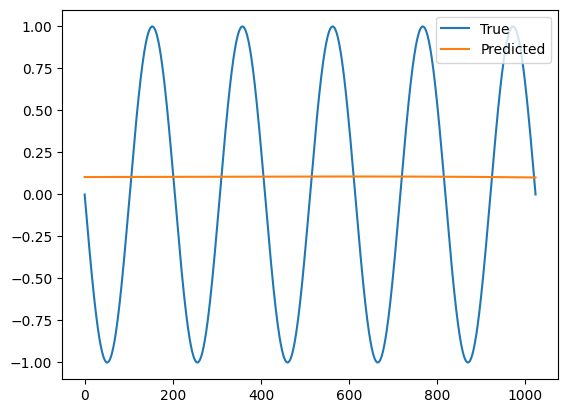

In [23]:
import matplotlib.pyplot as plt
model.eval()
x = torch.Tensor(x).to(device).unsqueeze(1)
with torch.no_grad():
    u_pred = model(x).cpu().numpy()
plt.plot(u_true, label="True")
plt.plot(u_pred, label="Predicted")
# plt.plot(u_train, label="Noisy")
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt

with torch.no_grad():
    u_pred = model(train).cpu().numpy()
plt.imshow(u_pred.reshape(101, 101), cmap="viridis")
plt.colorbar()
plt.show()

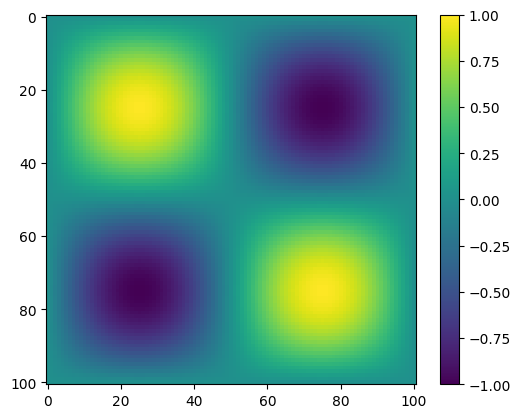

In [45]:
plt.imshow(u_true, cmap="viridis")
plt.colorbar()
plt.show()

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from tqdm import tqdm

def visualize_helmholtz(X, Y, data, path):
    """
    Visualizes the 2D Helmholtz solution as an animation.

    Args:
    X, Y : Meshgrid coordinates for plotting
    data : 3D NumPy array [time, X, Y] representing the solution at different times
    path : Path to save the animation
    """
    fig, ax = plt.subplots()

    # Use contour plot or imshow
    im = ax.imshow(data[0], extent=[X.min(), X.max(), Y.min(), Y.max()],
                   origin='lower', cmap='viridis', animated=True)
    ax.set_xlabel("X-axis")
    ax.set_ylabel("Y-axis")
    ax.set_title("Helmholtz Equation Solution Animation")

    def update(frame):
        im.set_array(data[frame])  # Update solution at new time step
        return [im]

    ani = animation.FuncAnimation(fig, update, frames=len(data), interval=50, blit=False)

    writer = animation.PillowWriter(fps=15, bitrate=1800)
    ani.save(path, writer=writer)
    plt.close(fig)

# Example Usage
# Generate example Helmholtz solution data
# x = np.linspace(-1, 1, 100)
# y = np.linspace(-1, 1, 100)
# X, Y = np.meshgrid(x, y)

# # Example 2D Helmholtz wave solution evolving over time
# time_steps = 50
# a1, a2 = 1, 1
# data = np.array([np.sin(a1 * np.pi * X) * np.sin(a2 * np.pi * Y) * np.cos(2 * np.pi * t / time_steps)
#                  for t in range(time_steps)])

# Visualize and save
# visualize_helmholtz(X, Y, data, "helmholtz_solution.gif")

In [13]:
x, y = X_train[:1024], Y_train[:1024]
X, Y = np.meshgrid(x.cpu().numpy(), y.cpu().numpy())
a = torch.stack((x, y), dim=1).to(device)
u = model(a).detach().cpu().nump


y().reshape(32, 32)
u.shape, X.shape, Y.shape

((32, 32), (1024, 1024), (1024, 1024))

In [50]:
# Create 50 time steps by adding small variations (e.g., sine wave modulation)
t = np.linspace(0, 2 * np.pi, 50)
u_time_series = np.array([u_true * np.sin(ti) for ti in t])
# u_time_series = u_time_series[:, :, :]
u_time_series.shape

(50, 101, 101)

In [51]:
visualize_helmholtz(X, Y, u_time_series, "helmholtz_solution.gif")